In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from sklearn.metrics import silhouette_score


In [2]:
df = pd.read_parquet('../data/Electric_Vehicle_Population_Data_cleaned.parquet')
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,CAFV_Class,Vehicle_Age,longitude,latitude
0,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),220.0,59900.0,37.0,477309682,POINT (-122.23825 47.49461),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,1,6,-122.23825,47.49461
1,5YJYGDEE3L,Kitsap,Poulsbo,WA,98370.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),291.0,59900.0,23.0,109705683,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303509e+10,1,5,-122.64681,47.73689
2,KM8KRDAF5P,Kitsap,Olalla,WA,98359.0,2023,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),72.0,59900.0,26.0,230390492,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10,0,2,-122.54729,47.42602
3,5UXTA6C0XM,Kitsap,Seabeck,WA,98380.0,2021,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),30.0,59900.0,35.0,267929112,POINT (-122.81585 47.64509),PUGET SOUND ENERGY INC,5.303509e+10,1,4,-122.81585,47.64509
4,JTMAB3FV7P,Thurston,Rainier,WA,98576.0,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),42.0,59900.0,2.0,236505139,POINT (-122.68993 46.88897),PUGET SOUND ENERGY INC,5.306701e+10,1,2,-122.68993,46.88897


In [3]:
features = ['Electric Range', 'Vehicle_Age', 'Base MSRP']
df_features = df[features].copy()
df_features['EV_Type'] = df['Electric Vehicle Type'].map({'Battery Electric Vehicle (BEV)': 1, 'Plug-in Hybrid Electric Vehicle (PHEV)': 0})
df_features['Make_encoded'] = pd.factorize(df['Make'])[0]
df_features.head()

,Electric Range,Vehicle_Age,Base MSRP,EV_Type,Make_encoded
0,220.0,6,59900.0,1,0
1,291.0,5,59900.0,1,0
2,72.0,2,59900.0,1,1
3,30.0,4,59900.0,0,2
4,42.0,2,59900.0,0,3


In [4]:
features_for_clustering = ['Electric Range', 'Vehicle_Age', 'Base MSRP', 'EV_Type', 'Make_encoded']
X = df_features[features_for_clustering]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [5]:
sample_size = min(3000, int(0.1 * len(df_features)))
np.random.seed(42)
sample_indices = np.random.choice(len(df_features), sample_size, replace=False)
X_sample = scaled_features[sample_indices]

In [6]:
affinity_prop = AffinityPropagation(
    damping=0.9,
    max_iter=200,
    convergence_iter=15,
    random_state=42,
    preference=-500  
)
cluster_labels = affinity_prop.fit_predict(X_sample)
n_clusters_ap = len(set(cluster_labels))
print(f"Anzahl der identifizierten Cluster: {n_clusters_ap}")

exemplar_indices = affinity_prop.cluster_centers_indices_
print(f"Anzahl der Exemplare: {len(exemplar_indices)}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

Anzahl der identifizierten Cluster: 7
Anzahl der Exemplare: 7


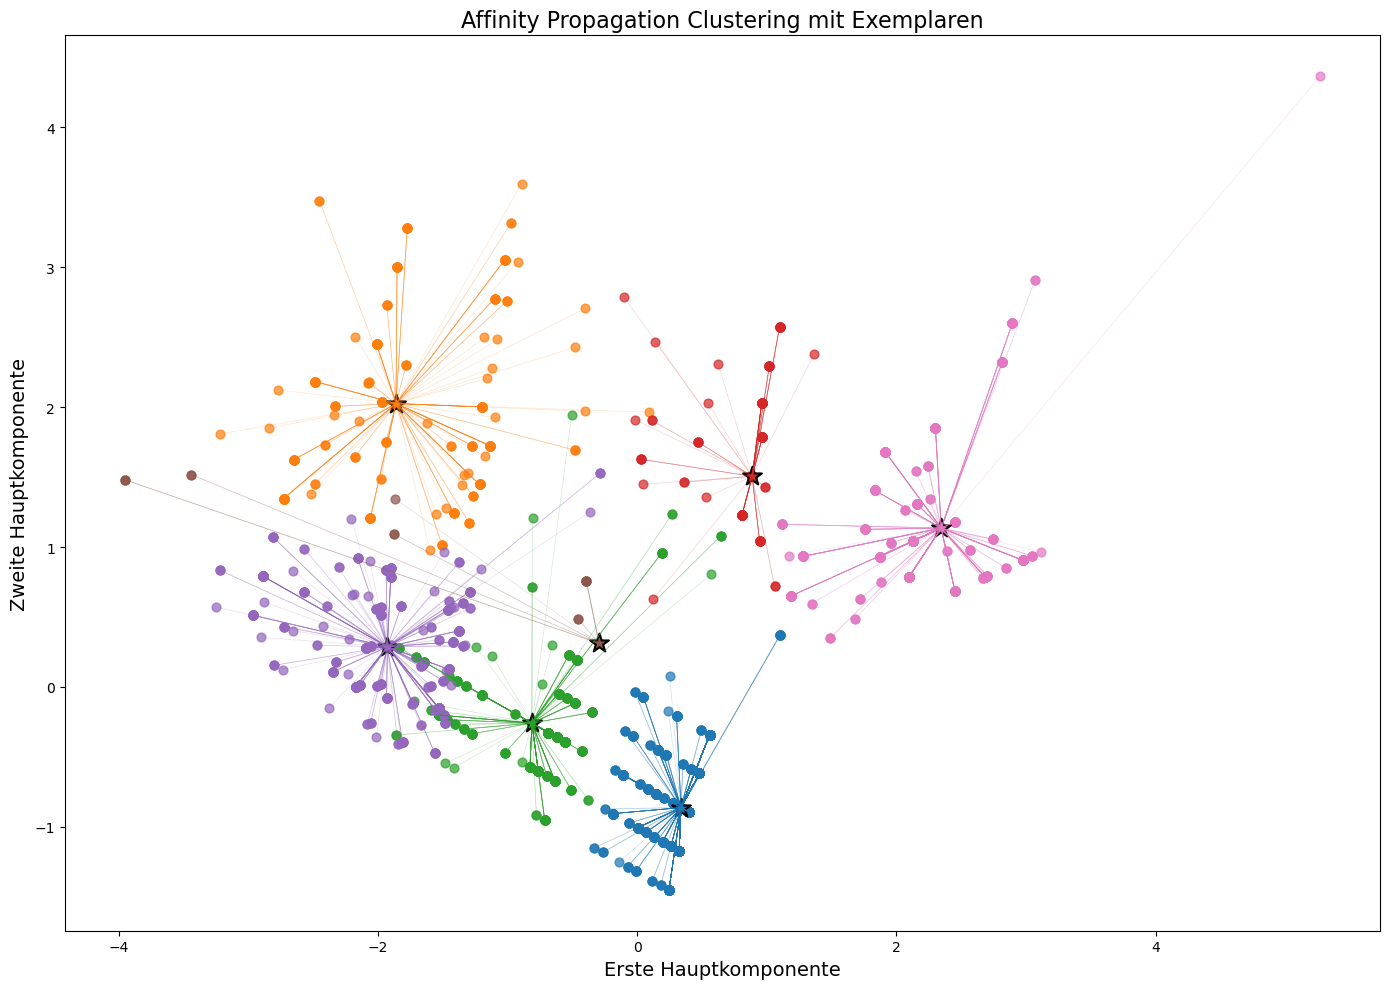

In [7]:
colors = list(mcolors.TABLEAU_COLORS.values())
color_map = {i: colors[i % len(colors)] for i in range(n_clusters_ap)}

plt.figure(figsize=(14, 10))

for i, exemplar_idx in enumerate(exemplar_indices):
    cluster_label = cluster_labels[exemplar_idx]
    member_indices = np.where(cluster_labels == cluster_label)[0]
    
    color = color_map[i % len(color_map)]
    
    for member_idx in member_indices:
        if member_idx == exemplar_idx:
            continue
            
        plt.plot(
            [X_pca[exemplar_idx, 0], X_pca[member_idx, 0]],
            [X_pca[exemplar_idx, 1], X_pca[member_idx, 1]],
            color=color,
            alpha=0.2,
            linewidth=0.5
        )
    
    # Zeichne Clusterpunkte
    plt.scatter(
        X_pca[member_indices, 0],
        X_pca[member_indices, 1],
        s=40,
        color=color,
        alpha=0.7,
        label=f'Cluster {i}'
    )
    
    # Markiere das Exemplar
    plt.scatter(
        X_pca[exemplar_idx, 0],
        X_pca[exemplar_idx, 1],
        s=200,
        color=color,
        marker='*',
        edgecolor='black',
        linewidth=1.5
    )

plt.title('Affinity Propagation Clustering mit Exemplaren', fontsize=16)
plt.xlabel('Erste Hauptkomponente', fontsize=14)
plt.ylabel('Zweite Hauptkomponente', fontsize=14)
# if n_clusters_ap <= 10:
#     plt.legend(title="Cluster", loc='best')

plt.tight_layout()
plt.show()

In [11]:
df_sample = pd.DataFrame(data=X_sample, columns=features_for_clustering)
df_sample['Cluster_Label'] = cluster_labels  # Die originalen Cluster-Labels

# Erstelle eine Zuordnung von Exemplar-Index zu Cluster-Nummer
exemplar_to_cluster = {exemplar_idx: i for i, exemplar_idx in enumerate(exemplar_indices)}

# Erstelle eine neue Spalte mit den konsistenten Cluster-Nummern (0 bis n-1)
df_sample['Cluster'] = -1  # Initialisiere mit -1
for i, label in enumerate(cluster_labels):
    # Finde das Exemplar für dieses Label
    for exemplar_idx in exemplar_indices:
        if cluster_labels[exemplar_idx] == label:
            df_sample.loc[i, 'Cluster'] = exemplar_to_cluster[exemplar_idx]
            break

# Originale Features aus df_features hinzufügen
orig_features = df_features.iloc[sample_indices].reset_index(drop=True)
df_sample['Electric Range'] = orig_features['Electric Range']
df_sample['Vehicle_Age'] = orig_features['Vehicle_Age'] 
df_sample['Base MSRP'] = orig_features['Base MSRP']
df_sample['EV_Type'] = orig_features['EV_Type']

# Cluster-Statistiken basierend auf den konsistenten Cluster-Nummern
cluster_stats = df_sample.groupby('Cluster').agg({
    'Electric Range': 'mean',
    'Vehicle_Age': 'mean',
    'Base MSRP': 'mean',
    'EV_Type': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

# Formatieren
cluster_stats['Electric Range'] = cluster_stats['Electric Range'].round(1)
cluster_stats['Vehicle_Age'] = cluster_stats['Vehicle_Age'].round(1)
cluster_stats['Base MSRP'] = cluster_stats['Base MSRP'].round(0)
cluster_stats['EV_Type'] = cluster_stats['EV_Type'].round(3)
cluster_stats['Percentage'] = (cluster_stats['Count'] / cluster_stats['Count'].sum() * 100).round(1)

print("\nCluster-Eigenschaften:")
display(cluster_stats)

# Zeige exemplarische Fahrzeuge
print("\nExemplarische Fahrzeuge (Cluster-Zentren):")
exemplars_original_indices = sample_indices[exemplar_indices]
exemplars_df = df.iloc[exemplars_original_indices][['Make', 'Model', 'Electric Vehicle Type', 'Electric Range', 'Base MSRP']]

# Füge konsistente Cluster-Nummern hinzu
exemplars_df['Cluster'] = [i for i in range(len(exemplar_indices))]
exemplars_df = exemplars_df.set_index('Cluster')

display(exemplars_df)


Cluster-Eigenschaften:


,Electric Range,Vehicle_Age,Base MSRP,EV_Type,Count,Percentage
Cluster,,,,,,
0,72.4,2.0,59900.0,1.0,1393,46.4
1,29.8,7.8,59768.0,0.0,224,7.5
2,74.7,2.0,59900.0,1.0,405,13.5
3,83.1,10.5,59900.0,1.0,127,4.2
4,31.6,2.0,59900.0,0.0,401,13.4
5,56.5,7.5,36512.0,0.5,16,0.5
6,233.6,6.7,60594.0,1.0,434,14.5



Exemplarische Fahrzeuge (Cluster-Zentren):


,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP
Cluster,,,,,
0,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),72.0,59900.0
1,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),16.0,59900.0
2,PORSCHE,TAYCAN,Battery Electric Vehicle (BEV),72.0,59900.0
3,NISSAN,LEAF,Battery Electric Vehicle (BEV),84.0,59900.0
4,VOLVO,XC90,Plug-in Hybrid Electric Vehicle (PHEV),32.0,59900.0
5,KIA,SOUL EV,Battery Electric Vehicle (BEV),111.0,33950.0
6,TESLA,MODEL X,Battery Electric Vehicle (BEV),238.0,59900.0
